# Normalizing Flow Models

**Author**: Chris Oswald

**Course**: CS676/ECE689 Advanced Topics in Deep Learning (Spring 2024)


## Question 1: Normalizing Flows

- Select a coupling Normalizing Flow and an autoregressive Normalizing Flow (NF).
- Apply the NF models to MNIST dataset.
- You can resize the MNIST images to 7 × 7 pixels to reduce computational complexity.



## Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
models_dir = "./drive/MyDrive/Colab Notebooks/Models"
os.makedirs(models_dir, exist_ok=True)

## Imports and Datasets

In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=a3f45c9cc5f107fb3dc5faae7d8d6fd88c27f15fb76b7e01d981591fac80c03f
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torch.distributions.multivariate_normal import MultivariateNormal

import normflows as nf

import copy

%matplotlib inline

In [ ]:
# Import resized MNIST data
ds_MNIST_7 = torchvision.datasets.MNIST(
    "MNIST/train",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(7),
        torchvision.transforms.ToTensor(),
    ])
)

100%|██████████| 9912422/9912422 [00:00<00:00, 35408415.13it/s]


Extracting MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52258711.74it/s]


Extracting MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26116921.50it/s]


Extracting MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7011604.26it/s]


Extracting MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/train/MNIST/raw



In [ ]:
ds_MNIST_7

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=7, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

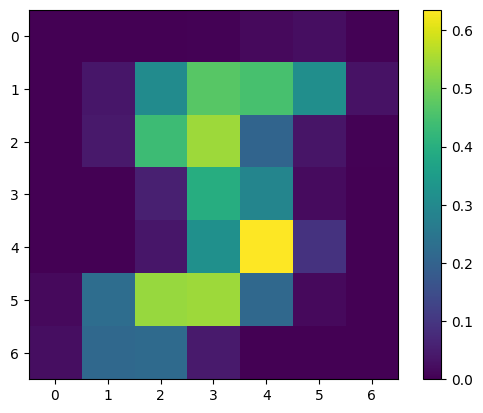

In [ ]:
# Confirm that dataset was loaded
first_image, first_label = ds_MNIST_7[0]
first_image = first_image.numpy().transpose(1, 2, 0)
image_plot = plt.imshow(first_image)
plt.colorbar(image_plot, orientation="vertical")

References:

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


## Coupling NF using `normflows` Package

References:

- https://github.com/VincentStimper/normalizing-flows/blob/master/examples/real_nvp.ipynb
- https://github.com/VincentStimper/normalizing-flows/tree/master
- https://arxiv.org/abs/1605.08803




In [ ]:
torch.manual_seed(9999)
n_flows = 64

# Create flow layers
n_dim =  ds_MNIST_7[0][0].flatten().shape[0]
mask = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(n_dim)])
flows = []
for i in range(n_flows):
    s = nf.nets.MLP([n_dim, 128, n_dim], init_zeros=True)
    t = nf.nets.MLP([n_dim, 128, n_dim], init_zeros=True)
    if i % 2 == 0:
        flows.append(nf.flows.MaskedAffineFlow(mask, t, s))
    else:
        flows.append(nf.flows.MaskedAffineFlow((1-mask), t, s))

# Set base distribution
base_dist = nf.distributions.DiagGaussian(n_dim)

# Create model
model = nf.NormalizingFlow(q0=base_dist, flows=flows)
model = model.to(device).float()

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [ ]:
# Load/train model
load_model = False
load_model_name = ""
load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(load_model_path))
    else:
        model.load_state_dict(
            torch.load(load_model_path, map_location=torch.device("cpu"))
        )
else:
    batch_size = 64
    epochs = 20

    dl = DataLoader(ds_MNIST_7, batch_size=batch_size, shuffle=True, drop_last=True)
    size = len(dl.dataset)

    lowest_avg_loss = None

    model.train()
    for t in range(epochs):
        loss_vals = []
        print(f"Epoch {t+1}\n{'-'*10}")
        for batch, (X, _) in enumerate(dl):
            X = X.to(device).view(batch_size, n_dim)

            loss = model.forward_kld(X)

            if ~(torch.isnan(loss) | torch.isinf(loss)):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Record training batch loss
                loss_val = loss.item()
                loss_vals.append(loss_val)

            # Report loss and current batch
            if batch % 100 == 0:
                current_batch = (batch + 1) * len(X)
                print(f"Loss: {loss_val:>7f} [{current_batch:>5d}/{size:>5d}]")

        # Save model if improving
        epoch_avg_loss = np.mean(loss_vals)
        if (lowest_avg_loss is None) or (epoch_avg_loss < lowest_avg_loss):
            lowest_avg_loss = epoch_avg_loss
            model.save(os.path.join(models_dir, f'CouplingNFmodel_epoch{t+1}.pt'))
            print(f'Saved model for epoch {t+1}')

Epoch 1
----------
Loss: 46.350960 [   64/60000]
Loss: -38.612244 [ 6464/60000]
Loss: -54.118797 [12864/60000]
Loss: -16.705276 [19264/60000]
Loss: -49.343594 [25664/60000]
Loss: -66.319069 [32064/60000]
Loss: -71.114601 [38464/60000]
Loss: -36.772881 [44864/60000]
Loss: -69.157990 [51264/60000]
Loss: -74.999390 [57664/60000]
Saved model for epoch 1
Epoch 2
----------
Loss: -77.376366 [   64/60000]
Loss: -80.536125 [ 6464/60000]
Loss: -88.496643 [12864/60000]
Loss: -93.090347 [19264/60000]
Loss: -96.961960 [25664/60000]
Loss: -91.442169 [32064/60000]
Loss: -97.418610 [38464/60000]
Loss: -96.233917 [44864/60000]
Loss: 2.053486 [51264/60000]
Loss: -30.322399 [57664/60000]
Epoch 3
----------
Loss: -38.387138 [   64/60000]
Loss: -45.206577 [ 6464/60000]
Loss: -53.723839 [12864/60000]
Loss: -62.587383 [19264/60000]
Loss: -57.706299 [25664/60000]
Loss: -69.507645 [32064/60000]
Loss: -74.777267 [38464/60000]
Loss: -81.065323 [44864/60000]
Loss: -78.276810 [51264/60000]
Loss: -78.559601 [57664

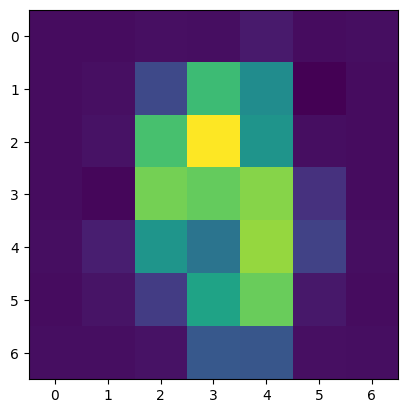

In [ ]:
# Sample from model
z, _ = model.sample(1)
z = z.to('cpu').view(7, 7).detach().numpy()
plt.imshow(z)

## Autoregressive NF using `normflows` Package

References:

- https://github.com/VincentStimper/normalizing-flows/blob/master/normflows/flows/affine/autoregressive.py
- https://github.com/bayesiains/nflows/blob/master/nflows/flows/autoregressive.py


In [ ]:
torch.manual_seed(8888)
n_flows = 16 # Setting to 64 results in NaN loss values for all batches

# Create flow layers
n_dim =  ds_MNIST_7[0][0].flatten().shape[0]
flows = []
for i in range(n_flows):
    flows.append(
        nf.flows.MaskedAffineAutoregressive(
            features=n_dim,
            hidden_features=32,
            use_batch_norm=True,
        )
    )

# Set base distribution
base_dist = nf.distributions.DiagGaussian(n_dim)

# Create model
model = nf.NormalizingFlow(q0=base_dist, flows=flows)
model = model.to(device).float()

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [ ]:
# Load/train model
load_model = False
load_model_name = ""
load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(load_model_path))
    else:
        model.load_state_dict(
            torch.load(load_model_path, map_location=torch.device("cpu"))
        )
else:
    batch_size = 128
    epochs = 20

    dl = DataLoader(ds_MNIST_7, batch_size=batch_size, shuffle=True, drop_last=True)
    size = len(dl.dataset)

    lowest_avg_loss = None

    model.train()
    for t in range(epochs):
        batch_losses = []
        for batch, (X, _) in enumerate(dl):
            X = X.to(device).view(batch_size, n_dim)

            loss = model.forward_kld(X)

            if ~(torch.isnan(loss) | torch.isinf(loss)):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

                # Record training batch loss
                loss_val = loss.item()
                batch_losses.append(loss_val)
            else:
                print(f'NaN/Inf loss for batch {batch}')

        epoch_avg_loss = np.mean(batch_losses)
        print(f"Loss: {epoch_avg_loss:>7f} [Epoch {t+1}/{epochs}]")

        # Save model if improving
        epoch_avg_loss = np.mean(batch_losses)
        if (lowest_avg_loss is None) or (epoch_avg_loss < lowest_avg_loss):
            lowest_avg_loss = epoch_avg_loss
            model.save(os.path.join(models_dir, f'AutoRegNFmodel_epoch{t+1}.pt'))
            print(f'Saved model for epoch {t+1}')

Loss: -15.754591 [Epoch 1/20]
Saved model for epoch 1
Loss: -53.520104 [Epoch 2/20]
Saved model for epoch 2
Loss: -65.260176 [Epoch 3/20]
Saved model for epoch 3
Loss: -72.265711 [Epoch 4/20]
Saved model for epoch 4
Loss: -77.885487 [Epoch 5/20]
Saved model for epoch 5
Loss: -82.726488 [Epoch 6/20]
Saved model for epoch 6
Loss: -85.938771 [Epoch 7/20]
Saved model for epoch 7
Loss: -88.381940 [Epoch 8/20]
Saved model for epoch 8
Loss: -90.497325 [Epoch 9/20]
Saved model for epoch 9
Loss: -92.321800 [Epoch 10/20]
Saved model for epoch 10
Loss: -94.048842 [Epoch 11/20]
Saved model for epoch 11
Loss: -95.558981 [Epoch 12/20]
Saved model for epoch 12
Loss: -97.004938 [Epoch 13/20]
Saved model for epoch 13
Loss: -98.177051 [Epoch 14/20]
Saved model for epoch 14
Loss: -99.440532 [Epoch 15/20]
Saved model for epoch 15
Loss: -100.473484 [Epoch 16/20]
Saved model for epoch 16
Loss: -101.376469 [Epoch 17/20]
Saved model for epoch 17
Loss: -102.165986 [Epoch 18/20]
Saved model for epoch 18
Loss: -

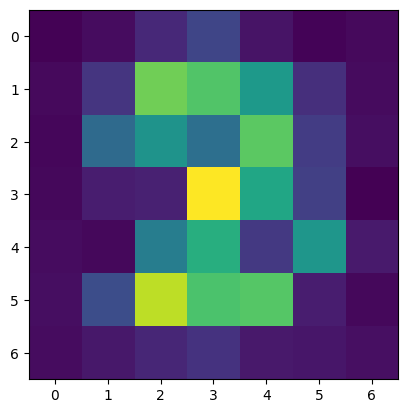

In [ ]:
# Sample from model
z, _ = model.sample(2)
z = z.view(2, 7, 7).to("cpu").detach().numpy()
plt.imshow(z[0])

## *Archived Attempts [For Reference]*

### NF Model from Scratch

References:

- https://github.com/karpathy/pytorch-normalizing-flows
- https://github.com/VincentStimper/normalizing-flows/tree/master

In [ ]:
# class MLP(nn.Module):
#     """Multi-layer perceptron feedforward neural network"""

#     def __init__(self, n_input: int, n_output: int, n_hidden: int = 64) -> None:
#         """
#         Initializes sequential linear model with 2 hidden layers and
#         leaky ReLU activation function.
#         """
#         super().__init__()
#         self.seq_net = nn.Sequential(
#             nn.Linear(n_input, n_hidden),
#             nn.LeakyReLU(0),
#             nn.Linear(n_hidden, n_hidden),
#             nn.LeakyReLU(0),
#             nn.Linear(n_hidden, n_output)
#         )

#     def forward(self, x: torch.Tensor):
#         output = self.seq_net(x)
#         return output


# class CNN(nn.Module):
#     """
#     Based on: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#     """

#     def __init__(
#         self,
#         in_channels: int,
#         height: int,
#         width: int,
#         n_output: int
#     ) -> None:
#         """
#         Initializes convolutional neural network model.
#         """
#         super().__init__()
#         self.seq_cnn = nn.Sequential(
#             nn.Conv2d(in_channels, 6, (height, width)),
#             nn.LeakyReLU(0),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(6, 16, (height, width)),
#             nn.LeakyReLU(0),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(16, 24, (height, width)),
#             nn.LeakyReLU(0),
#             nn.MaxPool2d(2, 2),
#             nn.Flatten(1, -1),
#             nn.Linear(24 * height * width, 120),
#             nn.Linear(120, 64),
#             nn.Linear(64, n_output),
#         )

#     def forward(self, x: torch.Tensor):
#         output = self.seq_cnn(x)
#         return output

In [ ]:
# class AffineCouplingLayer(nn.Module):
#     """
#     Affine coupling layer for RealNVP normalizing flow model.

#     Primarily based on https://github.com/karpathy/pytorch-normalizing-flows.
#     """

#     def __init__(self, dim: int, flip_order: bool):
#         super().__init__()
#         self.dim = dim
#         self.flip_order = flip_order
#         self.s_net = MLP((self.dim // 2), (self.dim // 2), 32)
#         self.t_net = MLP((self.dim // 2), (self.dim // 2), 32)

#     def forward(self, x: torch.Tensor):
#         x = x.view((x.shape[0], -1))
#         x0, x1 = x[:,::2], x[:,1::2] # Split tensor
#         if self.flip_order:
#             x0, x1 = x1, x0 # Alternate which sub-tensor is passed through identity matrix
#         s = self.s_net(x0) # Calculate scale parameter
#         t = self.t_net(x0) # Calculate shift parameter
#         z0 = x0 # Pass sub-tensor through identity matrix
#         z1 = torch.exp(s) * x1 + t # Transform other sub-tensor
#         if self.flip_order:
#             z0, z1 = z1, z0 # Restore order before concatenating together
#         z = torch.cat([z0, z1], dim=1)
#         log_det = torch.sum(s, dim=1)
#         return z, log_det

#     def backward(self, z: torch.Tensor):
#         z0, z1 = z[:, ::2], z[:,1::2]
#         if self.flip_order:
#             z0, z1 = z1, z0
#         s = self.s_net(z0)
#         t = self.t_net(z0)
#         x0 = z0
#         x1 = (z1 - t) * torch.exp(-s) # Inverse transformation
#         if self.flip_order:
#             x0, x1 = x1, x0
#         x = torch.cat([x0, x1], dim=1)
#         log_det = torch.sum(-s, dim=1)
#         return x, log_det

# class NFModel(nn.Module):
#     def __init__(self, base_dist, flows):
#         super().__init__()
#         self.base_dist = base_dist
#         self.flows = nn.ModuleList(flows)

#     def forward(self, x):
#         log_det = torch.zeros(x.shape[0]).to(device)
#         z_list = [x]
#         for flow_idx, flow in enumerate(self.flows):
#             x, log_det_i = flow(x)
#             log_det += log_det_i
#             # print(f'Log det type: {type(log_det)}')
#             x = torch.nan_to_num(x, nan=0, posinf=3, neginf=-3)
#             z_list.append(x)
#         log_prob_pz = (
#             self.base_dist.log_prob(z_list[-1]).view(x.size(0), -1).sum(1)
#         )
#         log_prob_pz = log_prob_pz
#         return z_list, log_prob_pz, log_det

#     def backward(self, z):
#         log_det = torch.zeros(z.shape[0]).to(device)
#         x_list = [z]
#         for flow_idx, flow in enumerate(self.flows[::-1]):
#             z, log_det_j = flow.backward(z)
#             log_det += log_det_j
#             x_list.append(z)
#         return x_list, log_det

#     def sample(self, n_samples):
#         z = self.base_dist.sample((n_samples,))
#         x_list, _ = self.backward(z)
#         return x_list

#     def save(self, path):
#         torch.save(self.state_dict(), path)

#     def load(self, path):
#         self.load_state_dict(torch.load(path))


In [ ]:
# n_flow_layers = 40
# n_dim = ds_MNIST[0][0].reshape(-1).shape[0] # MNIST (height x width pixels)

# mean_vec = torch.zeros(n_dim).to(device)
# cov_mat = torch.eye(n_dim).to(device)
# gaussian_prior = torch.distributions.MultivariateNormal(mean_vec, cov_mat) # pz(z) ~ MVN(0, I)
# flows = [
#     AffineCouplingLayer(dim=n_dim, flip_order=(idx % 2))
#     for idx in range(n_flow_layers)
# ]

# model = NFModel(gaussian_prior, flows).to(device)
# print(model)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# batch_size = 64
# epochs = 50

# dl = DataLoader(ds_MNIST, batch_size=batch_size, shuffle=True, drop_last=True)
# size = len(dl.dataset)

# lowest_avg_loss = None

# model.train()
# for t in range(epochs):
#     loss_vals = []
#     print(f"Epoch {t+1}\n{'-'*10}")
#     for batch, (X, _) in enumerate(dl):
#         X = X.to(device)

#         z_list, log_prob_pz, log_det = model(X)
#         # print(f'Log det type: {type(log_det)}')
#         # print(f'Log prob pz type: {type(log_prob_pz)}')

#         log_prob = log_prob_pz + log_det
#         # print(f'Log prob type: {type(log_prob)}')

#         loss = -torch.mean(log_prob)
#         # print(f'Loss type: {type(loss)}')

#         model.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Record training batch loss
#         loss_val = loss.item()
#         loss_vals.append(loss_val)
#         if batch % 100 == 0:
#             current_batch = (batch + 1) * len(X)
#             print(f"Loss: {loss_val:>7f} [{current_batch:>5d}/{size:>5d}]")

#     # Save model if improving
#     epoch_avg_loss = np.mean(loss_vals)
#     if (lowest_avg_loss is None) or (epoch_avg_loss < lowest_avg_loss):
#         lowest_avg_loss = epoch_avg_loss
#         model.save(os.path.join(models_dir, f'NFmodel_epoch{t}.pt'))
#         print(f'Saved model for epoch {t}')

In [ ]:
# # Sample from model
# model.eval()
# sampled_images = model.sample(1)

# first_image = sampled_images[0].view((7, 7))
# plt.imshow(first_image.cpu().detach().numpy())

# final_image = sampled_images[-1].view((7, 7))
# plt.imshow(final_image.cpu().detach().numpy())